# CNN for time series prediction

In [1]:
# source: https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

# multivariate cnn example
from numpy import array
from numpy import hstack
from math import floor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import StandardScaler
from util import load_hypocenters, PuuOo, load_puuoo_eqs, GetTimeToEruption, GetTimeSinceEruption, GetEQRates
import numpy as np
import random


Using TensorFlow backend.


In [2]:
# get dataset
# split a multivariate sequence into samples
def split_sequences(x_pre, y_pre, n_steps):
    X, y = list(), list()
    for i in range(len(x_pre)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(x_pre):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = x_pre[i:end_ix], y_pre[end_ix-1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [3]:
class BaseEarthquakes():
    """Earthquake and Eruption Dataset"""

    def __init__(self, root, eruption_csv_path, eq_csv_path, split):
        self.root  = root
        self.split = split
        self.eruption_csv_path = eruption_csv_path
        self.eq_csv_path = eq_csv_path
        self._get_east_rift_zone()
        self._set_x()
        self._normalize()
        self._add_time()
        
        self._split_data()

    def _add_time(self):
        self.max_time = np.max(self.time_since_beginning)
        self.min_time = np.min(self.time_since_beginning)
       
        self.time_since_beginning = (self.time_since_beginning - self.min_time)/(self.max_time - self.min_time)
        
        self.x = np.hstack((self.time_since_beginning[:, np.newaxis], self.x))
        
    def _set_x(self):
        
        self.time_since_beginning = np.array([(time - self.time[0]).total_seconds() for time in self.time])
        
        self.x = np.array([self.lat, self.lon, \
                            self.depth, self.mag]).T

        
    def _get_east_rift_zone(self): 
        self.p = PuuOo(self.eruption_csv_path)
        time, lat, lon, depth, mag = load_puuoo_eqs(self.eq_csv_path)
        
        latpts = np.array([19.3,19.5])
        lonpts = np.array([-155.5,-155])
        A      = np.array([lonpts,[1,1]]).T
        line   = np.linalg.solve(A, latpts)   
        croplocs = lat - line[0]*lon - line[1]        
        idx = [j for j in range(len(lon)) if croplocs[j]<=0]
        
        self.time = np.array(time)[idx]
        self.lat = np.array(lat)[idx]
        self.lon = np.array(lon)[idx]
        self.depth = np.array(depth)[idx]
        self.mag = np.array(mag)[idx]
        
    def _normalize(self):
        scaler = StandardScaler()
        scaler.fit(self.x)
        self.x = scaler.transform(self.x)
    
    def _split_data(self):
        # Create data list via train, val split

        if self.split in ["train", "val", "test"]:
          
            percent_train = 0.6 
            percent_val   = 0.1 # Percent test is what is left
            
            # Make additional array for erupting or not
            erupt = np.array([self.p.was_erupting(t) for t in self.time])
            
            num_erupt = np.sum(erupt)
            num_train = floor(percent_train * num_erupt)
            num_val   = floor(percent_val   * num_erupt)
            num_test  = num_erupt - num_train - num_val
            
            indices, = np.nonzero(erupt)
            idx_train = indices[num_train]
            idx_val   = indices[num_train + num_val]
            
            if self.split == "train":
                idx_start = 0
                idx_end   = idx_train
            elif self.split == "val":
                idx_start = idx_train
                idx_end   = idx_val
            elif self.split == "test":
                idx_start = idx_val
                idx_end   = len(erupt)
            
            # Split data
            self.time = self.time[idx_start : idx_end]
            self.x = self.x[idx_start : idx_end]
            self.y = erupt[idx_start : idx_end]
                    
        else:
            raise ValueError("Invalid split name: {}".format(self.split))

    def _get_label_weights(self):
        # Get weights for a given dataset
        num_erupt = np.sum(self.y)
        total = len(self.y)
        weights = [1, total/num_erupt]

        return weights
    
    def __getitem__(self, index):
        raise NotImplementedError
        
    def __len__(self):
        return len(self.erupt)

In [4]:
eruption_csv_path = 'PuuOo.csv'
eq_csv_path       = 'puuoo_earthquakes.csv' 

dataset_train = BaseEarthquakes(
        root=".",
        eruption_csv_path=eruption_csv_path, 
        eq_csv_path=eq_csv_path,    
        split="train",
    )

dataset_val = BaseEarthquakes(
        root=".",
        eruption_csv_path=eruption_csv_path, 
        eq_csv_path=eq_csv_path,    
        split="val",
    )

dataset_test = BaseEarthquakes(
        root=".",
        eruption_csv_path=eruption_csv_path, 
        eq_csv_path=eq_csv_path,    
        split="test",
    )

In [5]:
print(np.sum(dataset_train.y), np.sum(dataset_val.y), np.sum(dataset_test.y))
print(len(dataset_train.y), len(dataset_val.y), len(dataset_test.y))


506 84 254
2771 739 254


In [6]:
import matplotlib.pyplot as plt


In [7]:
class TimeDS(BaseEarthquakes):
    
    def __init__(self, **kwargs):
        super(TimeDS, self).__init__(**kwargs)
        self.derive_extra_features()
    
    def derive_extra_features(self):
        self.SecsToEruption = GetTimeToEruption(self.time, self.p)
        #self.SecsSinceEruption = GetTimeSinceEruption(self.time, self.p)
        #self.EQsLastDay, self.EQsLastWeek, self.EQsLastMonth = GetEQRates(self.time)
        #self.x = np.hstack((self.x, self.EQsLastMonth[:,np.newaxis]))
        self.y = self.SecsToEruption.reshape((-1,1))
        self.y = self.y / self.max_time * 10
        
    def __getitem__(self, index):
     
        return self.x[index], self.y[index]

In [8]:
dataset_train = TimeDS(
        root=".",
        eruption_csv_path=eruption_csv_path, 
        eq_csv_path=eq_csv_path,    
        split="train",
    )
dataset_val = TimeDS(
        root=".",
        eruption_csv_path=eruption_csv_path, 
        eq_csv_path=eq_csv_path,    
        split="val",
    )
dataset_test = TimeDS(
        root=".",
        eruption_csv_path=eruption_csv_path, 
        eq_csv_path=eq_csv_path,    
        split="test",
    )


In [9]:
dataset_train.y

array([[0.01360989],
       [0.01349239],
       [0.01345822],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

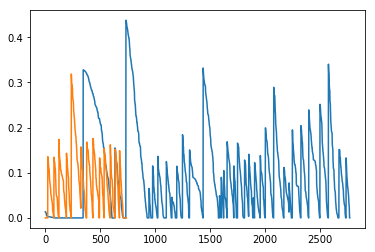

In [10]:
plt.plot(dataset_train.y)
plt.plot(dataset_val.y)

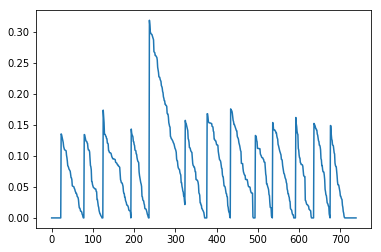

In [11]:
plt.plot(dataset_val.y)

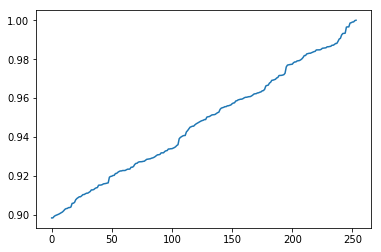

In [12]:
plt.plot(dataset_test.x[:,0])

In [13]:
def get_time_before_event(X):
    for i in range(X.shape[0]):
        X[i,:,0] = X[i,:,0] - X[i,-1,0]
    return X
    
    
n_steps = 20
X,Y = split_sequences(dataset_train.x, dataset_train.y, n_steps)
X = get_time_before_event(X)

In [14]:
X.shape

(2752, 20, 5)

## Build new model

In [15]:
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=n_features, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# fit model
model.fit(X, Y, epochs=1, verbose=1)



Epoch 1/1


In [ ]:
model.predict(X)